In [1]:
import sys
import os

# Assumes your notebook is in: latent-planning/notebooks/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from models.tinycnn import TinyCNN
from utils.inpca import inpca_embed_intensive

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [5]:
# Download and prepare MNIST dataset
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='~/.mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/.mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [6]:
import os, numpy as np, torch, torch.nn.functional as F
os.makedirs(f"{project_root}/data", exist_ok=True)

checkpoints = [0, 1, 5, 10, 30, 50]

In [13]:
# Training block
# Save probs to ./data/probs_epoch{ep}.npy

def eval_probs(model, loader):
    """Return (N_test,10) softmax matrix for ALL test images."""
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            probs = F.softmax(model(x), dim=1).cpu().numpy()
            all_probs.append(probs)
    return np.concatenate(all_probs)  # (10000, 10)

def eval_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

model = TinyCNN().to(device)

# ---------- 1. snapshot BEFORE training ----------
np.save(f"{project_root}/data/probs_epoch0.npy", eval_probs(model, test_loader))
print("Epoch 0 (untrained) acc =", eval_accuracy(model, test_loader))

# ---------- 2. train model ----------
opt = torch.optim.SGD(model.parameters(), lr=1e-3)  # (or Adam, RMSprop, etc. Adam converges within 5 epochs)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(1, max(checkpoints)+1)):
    # --- train one epoch ---
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); opt.step()

    # --- if in checkpoints then record ---
    if epoch in checkpoints:
        acc = eval_accuracy(model, test_loader)
        print(f"Epoch {epoch} test accuracy: {acc:.4f}")
        probs = eval_probs(model, test_loader)
        np.save(f"{project_root}/data/probs_epoch{epoch}.npy", probs)

Epoch 0 (untrained) acc = 0.0599


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 test accuracy: 0.3395


  8%|▊         | 4/50 [00:46<08:45, 11.43s/it]

Epoch 5 test accuracy: 0.8408


 18%|█▊        | 9/50 [01:33<06:26,  9.43s/it]

Epoch 10 test accuracy: 0.9046


 58%|█████▊    | 29/50 [05:04<03:33, 10.18s/it]

Epoch 30 test accuracy: 0.9496


 98%|█████████▊| 49/50 [08:20<00:09,  9.00s/it]

Epoch 50 test accuracy: 0.9673


100%|██████████| 50/50 [08:30<00:00, 10.22s/it]


In [ ]:
# Load probabilities
probs_list = [np.load(f"../data/probs_epoch{ep}.npy") for ep in checkpoints]


# Compute distances and embed
# inner = compute_inner_products(probs_list)
# D = compute_intensive_distance_matrix(inner)
# coords, eigvals = run_inpca(D)

# inner = compute_inner_products(probs_list)
# L      = compute_L_matrix(inner)          # L
# coords, eigvals = inpca_embed_intensive(L)   # W = P L P


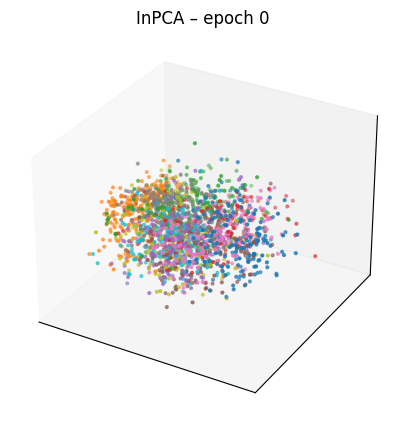

In [12]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401

# ----------- choose epoch to plot -----------
epoch_to_plot = 0                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

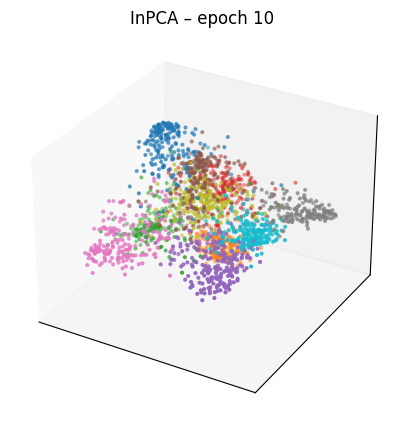

In [13]:
# ----------- choose epoch to plot -----------
epoch_to_plot = 10                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

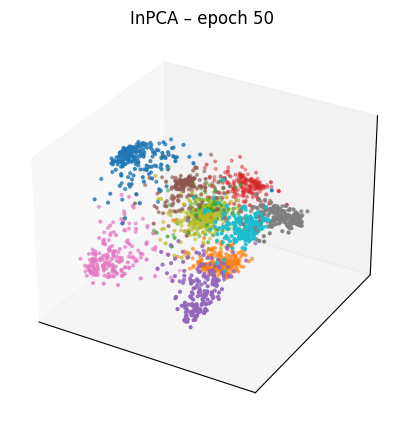

In [14]:
# ----------- choose epoch to plot -----------
epoch_to_plot = 50                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

In [ ]:
# ADD PLOTS